In [56]:
# Importar librerias
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import re # regex

from sklearn.tree import DecisionTreeClassifier
from sklearn.preprocessing import TargetEncoder
from sklearn.compose import make_column_transformer, make_column_selector
from sklearn.pipeline import make_pipeline

pd.set_option('display.max_columns', None)

In [4]:
# Lectura de archivo csv con el dataset
nba_data = pd.read_csv('data/pbp2023.csv')
print(nba_data.shape)
nba_data.head()

(646367, 16)


,gameid,period,clock,h_pts,a_pts,team,playerid,player,type,subtype,result,x,y,dist,desc,season
0,22200001,1,PT12M00.00S,0.0,0.0,NaN,0,NaN,period,start,NaN,0,0,0,Start of 1st Period (7:36 PM EST),2023
1,22200001,1,PT12M00.00S,NaN,NaN,BOS,201143,A. Horford,Jump Ball,NaN,NaN,0,0,0,Jump Ball Horford vs. Embiid: Tip to Harris,2023
2,22200001,1,PT11M38.00S,NaN,NaN,PHI,203954,J. Embiid,Missed Shot,Turnaround Fadeaway shot,Missed,-118,50,13,MISS Embiid 13' Turnaround Fadeaway Shot,2023
3,22200001,1,PT11M38.00S,NaN,NaN,BOS,1627759,J. Brown,NaN,NaN,NaN,0,0,0,Brown BLOCK (1 BLK),2023
4,22200001,1,PT11M35.00S,NaN,NaN,PHI,200782,P. Tucker,Rebound,Unknown,NaN,0,0,0,Tucker REBOUND (Off:1 Def:0),2023


In [5]:
nba_data.describe()

,gameid,period,h_pts,a_pts,playerid,x,y,dist,season
count,6.463670e+05,646367.000000,171676.000000,171676.000000,6.463670e+05,646367.000000,646367.000000,646367.000000,646367.0
mean,2.358362e+07,2.532608,59.968312,58.485152,9.619604e+07,-0.695065,34.103161,4.527672,2023.0
std,5.210566e+06,1.135909,34.694818,34.056075,3.792997e+08,68.013837,72.468474,8.852326,0.0
min,2.220000e+07,1.000000,0.000000,0.000000,0.000000e+00,-249.000000,-52.000000,0.000000,2023.0
25%,2.220033e+07,2.000000,30.000000,29.000000,2.039520e+05,0.000000,0.000000,0.000000,2023.0
50%,2.220066e+07,3.000000,60.000000,58.000000,1.628972e+06,0.000000,0.000000,0.000000,2023.0
75%,2.220099e+07,4.000000,88.000000,86.000000,1.630183e+06,0.000000,19.000000,3.000000,2023.0
max,5.220021e+07,6.000000,175.000000,176.000000,1.610613e+09,250.000000,820.000000,82.000000,2023.0


In [6]:
# Verificar valores unicos de columna 'season'
pd.unique(nba_data['season'])

array([2023])

In [7]:
# Eliminar columna 'season' ya que este dataset solo considera la temporada 2023
nba_data.drop('season',
  axis='columns', inplace=True)
nba_data

,gameid,period,clock,h_pts,a_pts,team,playerid,player,type,subtype,result,x,y,dist,desc
0,22200001,1,PT12M00.00S,0.0,0.0,NaN,0,NaN,period,start,NaN,0,0,0,Start of 1st Period (7:36 PM EST)
1,22200001,1,PT12M00.00S,NaN,NaN,BOS,201143,A. Horford,Jump Ball,NaN,NaN,0,0,0,Jump Ball Horford vs. Embiid: Tip to Harris
2,22200001,1,PT11M38.00S,NaN,NaN,PHI,203954,J. Embiid,Missed Shot,Turnaround Fadeaway shot,Missed,-118,50,13,MISS Embiid 13' Turnaround Fadeaway Shot
3,22200001,1,PT11M38.00S,NaN,NaN,BOS,1627759,J. Brown,NaN,NaN,NaN,0,0,0,Brown BLOCK (1 BLK)
4,22200001,1,PT11M35.00S,NaN,NaN,PHI,200782,P. Tucker,Rebound,Unknown,NaN,0,0,0,Tucker REBOUND (Off:1 Def:0)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
646362,52200211,4,PT00M50.80S,NaN,NaN,MIN,1629162,J. McLaughlin,NaN,NaN,NaN,0,0,0,McLaughlin STEAL (1 STL)
646363,52200211,4,PT00M47.50S,NaN,NaN,MIN,1630233,N. Knight,Turnover,Traveling,NaN,0,0,0,Knight Traveling Turnover (P2.T16)
646364,52200211,4,PT00M37.70S,120.0,95.0,OKC,1631172,O. Dieng,Made Shot,Driving Layup Shot,Made,6,13,1,Dieng 1' Driving Layup (4 PTS) (Mann 1 AST)
646365,52200211,4,PT00M13.60S,NaN,NaN,NaN,1610612750,NaN,Turnover,Shot Clock Turnover,NaN,0,0,0,TIMBERWOLVES Turnover: Shot Clock (T#17)


In [8]:
# Manejo de valores faltantes
# Comencemos examinando las columnas con una cantidad significativa de valores faltantes
missing_data = nba_data.isnull().sum()
print(missing_data[missing_data > 0])

h_pts      474691
a_pts      474691
team        51272
player      50515
type        31464
subtype     94962
result     413632
dtype: int64


In [9]:
# Verificar y mostrar duplicados
duplicates = nba_data[nba_data.duplicated(keep=False)]
print("Registros duplicados:")
duplicates.head()

Registros duplicados:


,gameid,period,clock,h_pts,a_pts,team,playerid,player,type,subtype,result,x,y,dist,desc
23928,22200047,3,PT04M53.00S,NaN,NaN,NaN,1628210,NaN,Foul,Technical,NaN,0,0,0,Joe Mazzulla Foul:T.FOUL (M.Davis)
23930,22200047,3,PT04M53.00S,NaN,NaN,NaN,1628210,NaN,Foul,Technical,NaN,0,0,0,Joe Mazzulla Foul:T.FOUL (M.Davis)
25138,22200049,4,PT01M28.00S,NaN,NaN,NaN,1610612763,NaN,Rebound,Unknown,NaN,0,0,0,GRIZZLIES Rebound
25140,22200049,4,PT01M28.00S,NaN,NaN,NaN,1610612763,NaN,Rebound,Unknown,NaN,0,0,0,GRIZZLIES Rebound
30447,22200060,3,PT04M24.00S,NaN,NaN,NaN,959,S. Nash,Foul,Technical,NaN,0,0,0,Steve Nash Foul:T.FOUL (J.Tiven)


In [10]:
# Eliminar si hay duplicados
duplicates = nba_data.duplicated().sum()
print(f"Número de entradas duplicadas: {duplicates}")
# Si decides eliminar duplicados
if duplicates > 0:
    nba_data = nba_data.drop_duplicates()

Número de entradas duplicadas: 169


In [11]:
# Convertir el formato de 'clock' de PT12M00.00S a minutos y segundos
# Extraemos los minutos y los segundos usando expresiones regulares

def parse_time(time_str):
    match = re.match(r'PT(\d+)M(\d+)\.\d+S', time_str)
    if match:
        return int(match.group(1)), int(match.group(2))
    return np.nan, np.nan  # Retorna NaN si no hay coincidencia

# Primero, aseguremos que estamos trabajando con un Dataframe completo, no un slice
nba_data = nba_data.copy()
# Aplicar la función para crear las columnas de minutos y segundos
nba_data['minutes'], nba_data['seconds'] = zip(*nba_data['clock'].apply(parse_time))

nba_data.head()

,gameid,period,clock,h_pts,a_pts,team,playerid,player,type,subtype,result,x,y,dist,desc,minutes,seconds
0,22200001,1,PT12M00.00S,0.0,0.0,NaN,0,NaN,period,start,NaN,0,0,0,Start of 1st Period (7:36 PM EST),12,0
1,22200001,1,PT12M00.00S,NaN,NaN,BOS,201143,A. Horford,Jump Ball,NaN,NaN,0,0,0,Jump Ball Horford vs. Embiid: Tip to Harris,12,0
2,22200001,1,PT11M38.00S,NaN,NaN,PHI,203954,J. Embiid,Missed Shot,Turnaround Fadeaway shot,Missed,-118,50,13,MISS Embiid 13' Turnaround Fadeaway Shot,11,38
3,22200001,1,PT11M38.00S,NaN,NaN,BOS,1627759,J. Brown,NaN,NaN,NaN,0,0,0,Brown BLOCK (1 BLK),11,38
4,22200001,1,PT11M35.00S,NaN,NaN,PHI,200782,P. Tucker,Rebound,Unknown,NaN,0,0,0,Tucker REBOUND (Off:1 Def:0),11,35


In [12]:
#Ordenamos los datos
nba_data = nba_data.sort_values(by=['gameid', 'period','minutes', 'seconds'], ascending=[True, True, False, False])

In [13]:
# Cambia valores de NAn a estas varables
nba_data['h_pts'] = nba_data['h_pts'].fillna(0).astype(int)
nba_data['a_pts'] = nba_data['a_pts'].fillna(0).astype(int)


In [14]:
# Crear una nueva característica para puntos totales si es necesario
nba_data['total_pts'] = nba_data['h_pts'] + nba_data['a_pts']
nba_data.head()



,gameid,period,clock,h_pts,a_pts,team,playerid,player,type,subtype,result,x,y,dist,desc,minutes,seconds,total_pts
0,22200001,1,PT12M00.00S,0,0,NaN,0,NaN,period,start,NaN,0,0,0,Start of 1st Period (7:36 PM EST),12,0,0
1,22200001,1,PT12M00.00S,0,0,BOS,201143,A. Horford,Jump Ball,NaN,NaN,0,0,0,Jump Ball Horford vs. Embiid: Tip to Harris,12,0,0
2,22200001,1,PT11M38.00S,0,0,PHI,203954,J. Embiid,Missed Shot,Turnaround Fadeaway shot,Missed,-118,50,13,MISS Embiid 13' Turnaround Fadeaway Shot,11,38,0
3,22200001,1,PT11M38.00S,0,0,BOS,1627759,J. Brown,NaN,NaN,NaN,0,0,0,Brown BLOCK (1 BLK),11,38,0
4,22200001,1,PT11M35.00S,0,0,PHI,200782,P. Tucker,Rebound,Unknown,NaN,0,0,0,Tucker REBOUND (Off:1 Def:0),11,35,0


In [15]:
# Crear una columna categórica para períodos para manejar tiempos extras de manera distinta
nba_data['game_stage'] = np.where(nba_data['period'] <= 4, 'Regular', 'Overtime')
nba_data.head()

,gameid,period,clock,h_pts,a_pts,team,playerid,player,type,subtype,result,x,y,dist,desc,minutes,seconds,total_pts,game_stage
0,22200001,1,PT12M00.00S,0,0,NaN,0,NaN,period,start,NaN,0,0,0,Start of 1st Period (7:36 PM EST),12,0,0,Regular
1,22200001,1,PT12M00.00S,0,0,BOS,201143,A. Horford,Jump Ball,NaN,NaN,0,0,0,Jump Ball Horford vs. Embiid: Tip to Harris,12,0,0,Regular
2,22200001,1,PT11M38.00S,0,0,PHI,203954,J. Embiid,Missed Shot,Turnaround Fadeaway shot,Missed,-118,50,13,MISS Embiid 13' Turnaround Fadeaway Shot,11,38,0,Regular
3,22200001,1,PT11M38.00S,0,0,BOS,1627759,J. Brown,NaN,NaN,NaN,0,0,0,Brown BLOCK (1 BLK),11,38,0,Regular
4,22200001,1,PT11M35.00S,0,0,PHI,200782,P. Tucker,Rebound,Unknown,NaN,0,0,0,Tucker REBOUND (Off:1 Def:0),11,35,0,Regular


In [16]:
# verificar si hay valores unicos en columna 'type'
unique_values = np.unique(nba_data['type'].astype(str))
unique_values

array(['Ejection', 'Foul', 'Foul                                    ',
       'Free Throw', 'Instant Replay',
       'Instant Replay                          ', 'Jump Ball',
       'Made Shot', 'Missed Shot', 'Rebound', 'Substitution', 'Timeout',
       'Turnover', 'Turnover                                ',
       'Violation', 'nan', 'period'], dtype=object)

In [17]:
# Eliminar espacios al principio y al final de las cadenas en la columna 'type'
nba_data['type'] = nba_data['type'].str.strip()

In [18]:
# Actualizar la columna 'type' si es que la columna 'desc' contiene la palabra 'BLOCK'

nba_data['type'] = nba_data.apply(lambda row: 'Block' if 'BLOCK' in row['desc'] else row['type'], axis=1)
nba_data.head(10)

,gameid,period,clock,h_pts,a_pts,team,playerid,player,type,subtype,result,x,y,dist,desc,minutes,seconds,total_pts,game_stage
0,22200001,1,PT12M00.00S,0,0,NaN,0,NaN,period,start,NaN,0,0,0,Start of 1st Period (7:36 PM EST),12,0,0,Regular
1,22200001,1,PT12M00.00S,0,0,BOS,201143,A. Horford,Jump Ball,NaN,NaN,0,0,0,Jump Ball Horford vs. Embiid: Tip to Harris,12,0,0,Regular
2,22200001,1,PT11M38.00S,0,0,PHI,203954,J. Embiid,Missed Shot,Turnaround Fadeaway shot,Missed,-118,50,13,MISS Embiid 13' Turnaround Fadeaway Shot,11,38,0,Regular
3,22200001,1,PT11M38.00S,0,0,BOS,1627759,J. Brown,Block,NaN,NaN,0,0,0,Brown BLOCK (1 BLK),11,38,0,Regular
4,22200001,1,PT11M35.00S,0,0,PHI,200782,P. Tucker,Rebound,Unknown,NaN,0,0,0,Tucker REBOUND (Off:1 Def:0),11,35,0,Regular
5,22200001,1,PT11M35.00S,0,0,PHI,200782,P. Tucker,Turnover,Out of Bounds Lost Ball Turnover,NaN,0,0,0,Tucker Out of Bounds Lost Ball Turnover (P1.T1),11,35,0,Regular
6,22200001,1,PT11M15.00S,2,0,BOS,203935,M. Smart,Made Shot,Driving Floating Bank Jump Shot,Made,120,55,13,Smart 13' Driving Floating Bank Jump Shot (2 PTS),11,15,2,Regular
7,22200001,1,PT11M05.00S,0,0,PHI,202699,T. Harris,Missed Shot,Driving Floating Jump Shot,Missed,50,135,14,MISS Harris 14' Driving Floating Jump Shot,11,5,0,Regular
8,22200001,1,PT11M05.00S,0,0,PHI,202699,T. Harris,Rebound,Unknown,NaN,0,0,0,Harris REBOUND (Off:1 Def:0),11,5,0,Regular
9,22200001,1,PT11M03.00S,2,2,PHI,202699,T. Harris,Made Shot,Tip Layup Shot,Made,0,0,0,Harris Tip Layup Shot (2 PTS),11,3,4,Regular


In [19]:
# Extrae el numero de la columna 'desc' si contiene la palabra 'BLOCK'
def extract_block_number(desc):
    if 'BLOCK' in desc:
        # Busca uno o mas digitos dentro del parentesis despues de 'BLOCK'
        match = re.search(r'BLOCK \((\d+) BLK\)', desc)
        if match:
            return int(match.group(1))
    return 0

# Aplicar la funcion para crear una columna 'block_number'
nba_data['block_number'] = nba_data['desc'].apply(extract_block_number)

nba_data.head(50)

,gameid,period,clock,h_pts,a_pts,team,playerid,player,type,subtype,result,x,y,dist,desc,minutes,seconds,total_pts,game_stage,block_number
0,22200001,1,PT12M00.00S,0,0,NaN,0,NaN,period,start,NaN,0,0,0,Start of 1st Period (7:36 PM EST),12,0,0,Regular,0
1,22200001,1,PT12M00.00S,0,0,BOS,201143,A. Horford,Jump Ball,NaN,NaN,0,0,0,Jump Ball Horford vs. Embiid: Tip to Harris,12,0,0,Regular,0
2,22200001,1,PT11M38.00S,0,0,PHI,203954,J. Embiid,Missed Shot,Turnaround Fadeaway shot,Missed,-118,50,13,MISS Embiid 13' Turnaround Fadeaway Shot,11,38,0,Regular,0
3,22200001,1,PT11M38.00S,0,0,BOS,1627759,J. Brown,Block,NaN,NaN,0,0,0,Brown BLOCK (1 BLK),11,38,0,Regular,1
4,22200001,1,PT11M35.00S,0,0,PHI,200782,P. Tucker,Rebound,Unknown,NaN,0,0,0,Tucker REBOUND (Off:1 Def:0),11,35,0,Regular,0
5,22200001,1,PT11M35.00S,0,0,PHI,200782,P. Tucker,Turnover,Out of Bounds Lost Ball Turnover,NaN,0,0,0,Tucker Out of Bounds Lost Ball Turnover (P1.T1),11,35,0,Regular,0
6,22200001,1,PT11M15.00S,2,0,BOS,203935,M. Smart,Made Shot,Driving Floating Bank Jump Shot,Made,120,55,13,Smart 13' Driving Floating Bank Jump Shot (2 PTS),11,15,2,Regular,0
7,22200001,1,PT11M05.00S,0,0,PHI,202699,T. Harris,Missed Shot,Driving Floating Jump Shot,Missed,50,135,14,MISS Harris 14' Driving Floating Jump Shot,11,5,0,Regular,0
8,22200001,1,PT11M05.00S,0,0,PHI,202699,T. Harris,Rebound,Unknown,NaN,0,0,0,Harris REBOUND (Off:1 Def:0),11,5,0,Regular,0
9,22200001,1,PT11M03.00S,2,2,PHI,202699,T. Harris,Made Shot,Tip Layup Shot,Made,0,0,0,Harris Tip Layup Shot (2 PTS),11,3,4,Regular,0


In [20]:
def extract_rebounds(desc):
    if 'REBOUND' in desc:
        # Buscar los patrones "Off:x" y "Def:y"
        off_match = re.search(r'Off:(\d+)', desc)
        def_match = re.search(r'Def:(\d+)', desc)
        # Extraer rebounds off y def si se encuentran coincidencias
        off_rebounds = int(off_match.group(1)) if off_match else 0
        def_rebounds = int(def_match.group(1)) if def_match else 0
        return off_rebounds, def_rebounds
    return 0, 0

# Aplicar la funcion a la columna 'desc' y crear dos nuevas columnas
nba_data['off_rebounds'], nba_data['def_rebounds'] = zip(*nba_data['desc'].apply(extract_rebounds))

nba_data[nba_data['type'] == 'Rebound'].head(50)

,gameid,period,clock,h_pts,a_pts,team,playerid,player,type,subtype,result,x,y,dist,desc,minutes,seconds,total_pts,game_stage,block_number,off_rebounds,def_rebounds
4,22200001,1,PT11M35.00S,0,0,PHI,200782,P. Tucker,Rebound,Unknown,NaN,0,0,0,Tucker REBOUND (Off:1 Def:0),11,35,0,Regular,0,1,0
8,22200001,1,PT11M05.00S,0,0,PHI,202699,T. Harris,Rebound,Unknown,NaN,0,0,0,Harris REBOUND (Off:1 Def:0),11,5,0,Regular,0,1,0
12,22200001,1,PT10M31.00S,0,0,BOS,1628369,J. Tatum,Rebound,Unknown,NaN,0,0,0,Tatum REBOUND (Off:0 Def:1),10,31,0,Regular,0,0,1
18,22200001,1,PT10M12.00S,0,0,NaN,1610612755,NaN,Rebound,Unknown,NaN,0,0,0,76ers Rebound,10,12,0,Regular,0,0,0
20,22200001,1,PT10M07.00S,0,0,BOS,201143,A. Horford,Rebound,Unknown,NaN,0,0,0,Horford REBOUND (Off:0 Def:1),10,7,0,Regular,0,0,1
23,22200001,1,PT10M04.00S,0,0,NaN,1610612738,NaN,Rebound,Unknown,NaN,0,0,0,CELTICS Rebound,10,4,0,Regular,0,0,0
26,22200001,1,PT09M51.00S,0,0,PHI,203954,J. Embiid,Rebound,Unknown,NaN,0,0,0,Embiid REBOUND (Off:0 Def:1),9,51,0,Regular,0,0,1
33,22200001,1,PT09M19.00S,0,0,BOS,1628401,D. White,Rebound,Unknown,NaN,0,0,0,White REBOUND (Off:1 Def:0),9,19,0,Regular,0,1,0
36,22200001,1,PT09M14.00S,0,0,PHI,201935,J. Harden,Rebound,Unknown,NaN,0,0,0,Harden REBOUND (Off:0 Def:1),9,14,0,Regular,0,0,1
38,22200001,1,PT08M49.00S,0,0,PHI,203954,J. Embiid,Rebound,Unknown,NaN,0,0,0,Embiid REBOUND (Off:1 Def:1),8,49,0,Regular,0,1,1


In [21]:
nba_data['type'] = nba_data.apply(lambda row: 'Steal' if 'STEAL' in row['desc'] else row['type'], axis=1)
nba_data[nba_data['type'] == 'Steal']

,gameid,period,clock,h_pts,a_pts,team,playerid,player,type,subtype,result,x,y,dist,desc,minutes,seconds,total_pts,game_stage,block_number,off_rebounds,def_rebounds
28,22200001,1,PT09M47.00S,0,0,BOS,203935,M. Smart,Steal,NaN,NaN,0,0,0,Smart STEAL (1 STL),9,47,0,Regular,0,0,0
58,22200001,1,PT07M35.00S,0,0,PHI,202699,T. Harris,Steal,NaN,NaN,0,0,0,Harris STEAL (1 STL),7,35,0,Regular,0,0,0
71,22200001,1,PT06M14.00S,0,0,PHI,1630178,T. Maxey,Steal,NaN,NaN,0,0,0,Maxey STEAL (1 STL),6,14,0,Regular,0,0,0
84,22200001,1,PT04M47.00S,0,0,BOS,1627763,M. Brogdon,Steal,NaN,NaN,0,0,0,Brogdon STEAL (1 STL),4,47,0,Regular,0,0,0
124,22200001,1,PT01M42.00S,0,0,PHI,1629001,D. Melton,Steal,NaN,NaN,0,0,0,Melton STEAL (1 STL),1,42,0,Regular,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
646291,52200211,4,PT08M01.00S,0,0,OKC,1631114,J. Williams,Steal,NaN,NaN,0,0,0,Jal. Williams STEAL (3 STL),8,1,0,Regular,0,0,0
646293,52200211,4,PT07M55.00S,0,0,MIN,201144,M. Conley,Steal,NaN,NaN,0,0,0,Conley STEAL (3 STL),7,55,0,Regular,0,0,0
646333,52200211,4,PT04M08.00S,0,0,MIN,1627752,T. Prince,Steal,NaN,NaN,0,0,0,Prince STEAL (1 STL),4,8,0,Regular,0,0,0
646357,52200211,4,PT01M15.00S,0,0,MIN,1630233,N. Knight,Steal,NaN,NaN,0,0,0,Knight STEAL (1 STL),1,15,0,Regular,0,0,0


In [22]:
# Extrae el numero de la columna 'desc' si contiene la palabra 'STEAL'
def extract_steal_number(desc):
    if 'STEAL' in desc:
        # Busca uno o mas digitos dentro del parentesis despues de 'STEAL'
        match = re.search(r'STEAL \((\d+) STL\)', desc)
        if match:
            return int(match.group(1))
    return 0

# Aplicar la funcion para crear una columna 'steal_number'
nba_data['steal_number'] = nba_data['desc'].apply(extract_steal_number)

nba_data[nba_data['type'] == 'Steal']

,gameid,period,clock,h_pts,a_pts,team,playerid,player,type,subtype,result,x,y,dist,desc,minutes,seconds,total_pts,game_stage,block_number,off_rebounds,def_rebounds,steal_number
28,22200001,1,PT09M47.00S,0,0,BOS,203935,M. Smart,Steal,NaN,NaN,0,0,0,Smart STEAL (1 STL),9,47,0,Regular,0,0,0,1
58,22200001,1,PT07M35.00S,0,0,PHI,202699,T. Harris,Steal,NaN,NaN,0,0,0,Harris STEAL (1 STL),7,35,0,Regular,0,0,0,1
71,22200001,1,PT06M14.00S,0,0,PHI,1630178,T. Maxey,Steal,NaN,NaN,0,0,0,Maxey STEAL (1 STL),6,14,0,Regular,0,0,0,1
84,22200001,1,PT04M47.00S,0,0,BOS,1627763,M. Brogdon,Steal,NaN,NaN,0,0,0,Brogdon STEAL (1 STL),4,47,0,Regular,0,0,0,1
124,22200001,1,PT01M42.00S,0,0,PHI,1629001,D. Melton,Steal,NaN,NaN,0,0,0,Melton STEAL (1 STL),1,42,0,Regular,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
646291,52200211,4,PT08M01.00S,0,0,OKC,1631114,J. Williams,Steal,NaN,NaN,0,0,0,Jal. Williams STEAL (3 STL),8,1,0,Regular,0,0,0,3
646293,52200211,4,PT07M55.00S,0,0,MIN,201144,M. Conley,Steal,NaN,NaN,0,0,0,Conley STEAL (3 STL),7,55,0,Regular,0,0,0,3
646333,52200211,4,PT04M08.00S,0,0,MIN,1627752,T. Prince,Steal,NaN,NaN,0,0,0,Prince STEAL (1 STL),4,8,0,Regular,0,0,0,1
646357,52200211,4,PT01M15.00S,0,0,MIN,1630233,N. Knight,Steal,NaN,NaN,0,0,0,Knight STEAL (1 STL),1,15,0,Regular,0,0,0,1


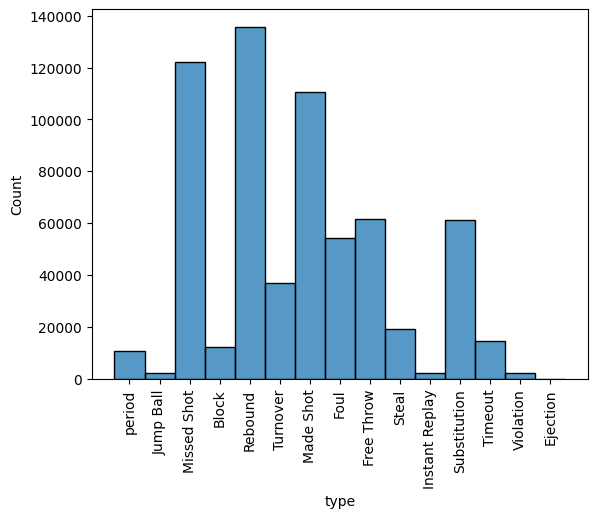

In [23]:
sns.histplot(data=nba_data, x='type')
plt.xticks(rotation=90)
plt.show()

In [24]:
nba_data.head()

,gameid,period,clock,h_pts,a_pts,team,playerid,player,type,subtype,result,x,y,dist,desc,minutes,seconds,total_pts,game_stage,block_number,off_rebounds,def_rebounds,steal_number
0,22200001,1,PT12M00.00S,0,0,NaN,0,NaN,period,start,NaN,0,0,0,Start of 1st Period (7:36 PM EST),12,0,0,Regular,0,0,0,0
1,22200001,1,PT12M00.00S,0,0,BOS,201143,A. Horford,Jump Ball,NaN,NaN,0,0,0,Jump Ball Horford vs. Embiid: Tip to Harris,12,0,0,Regular,0,0,0,0
2,22200001,1,PT11M38.00S,0,0,PHI,203954,J. Embiid,Missed Shot,Turnaround Fadeaway shot,Missed,-118,50,13,MISS Embiid 13' Turnaround Fadeaway Shot,11,38,0,Regular,0,0,0,0
3,22200001,1,PT11M38.00S,0,0,BOS,1627759,J. Brown,Block,NaN,NaN,0,0,0,Brown BLOCK (1 BLK),11,38,0,Regular,1,0,0,0
4,22200001,1,PT11M35.00S,0,0,PHI,200782,P. Tucker,Rebound,Unknown,NaN,0,0,0,Tucker REBOUND (Off:1 Def:0),11,35,0,Regular,0,1,0,0


In [25]:
nba_data.describe()

,gameid,period,h_pts,a_pts,playerid,x,y,dist,minutes,seconds,total_pts,block_number,off_rebounds,def_rebounds,steal_number
count,6.461980e+05,646198.000000,646198.000000,646198.000000,6.461980e+05,646198.000000,646198.000000,646198.000000,646198.000000,646198.000000,646198.000000,646198.000000,646198.000000,646198.000000,646198.000000
mean,2.358361e+07,2.532549,15.931835,15.537803,9.609636e+07,-0.695247,34.112080,4.528856,5.145941,28.174160,31.469638,0.027875,0.172288,0.538881,0.043841
std,5.210585e+06,1.135920,31.959001,31.231980,3.791131e+08,68.022729,72.475851,8.853181,3.479437,17.714283,62.943463,0.231579,0.657742,1.552443,0.284610
min,2.220000e+07,1.000000,0.000000,0.000000,0.000000e+00,-249.000000,-52.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.220033e+07,2.000000,0.000000,0.000000,2.039520e+05,0.000000,0.000000,0.000000,2.000000,13.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.220066e+07,3.000000,0.000000,0.000000,1.628972e+06,0.000000,0.000000,0.000000,5.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2.220099e+07,4.000000,7.000000,7.000000,1.630183e+06,0.000000,19.000000,3.000000,8.000000,43.000000,15.000000,0.000000,0.000000,0.000000,0.000000
max,5.220021e+07,6.000000,175.000000,176.000000,1.610613e+09,250.000000,820.000000,82.000000,12.000000,59.000000,351.000000,9.000000,14.000000,20.000000,7.000000


In [26]:
# Inicializar columnas para almacenar la diferencia
nba_data['h_pts_diff'] = 0
nba_data['a_pts_diff'] = 0

# Variables para almacenar los puntos acumulados de la última jugada donde se sumaron puntos
last_h_pts = 0
last_a_pts = 0
gameid = nba_data.iloc[0]['gameid']


# Iterar sobre las filas del DataFrame
for index, row in nba_data.iterrows():
    if row['gameid'] != gameid:
        gameid = row['gameid']
        last_h_pts = 0
        last_a_pts = 0

    if row['h_pts'] > 0 or row['a_pts'] > 0 :
        if row['h_pts'] > last_h_pts:
            nba_data.at[index, 'h_pts_diff'] = row['h_pts'] - last_h_pts
            last_h_pts = row['h_pts']
        if row['a_pts'] > last_a_pts:
            nba_data.at[index, 'a_pts_diff'] = row['a_pts'] - last_a_pts
            last_a_pts = row['a_pts']

# Asegurarse de que en una misma jugada solo un equipo sume puntos
nba_data.loc[(nba_data['h_pts_diff'] > 0) & (nba_data['a_pts_diff'] > 0), ['h_pts_diff', 'a_pts_diff']] = 0


In [27]:
nba_data.loc[(nba_data['h_pts_diff'] > 0) | (nba_data['a_pts_diff'] > 0), 'result'] = 'Made'
nba_data.head(50)

,gameid,period,clock,h_pts,a_pts,team,playerid,player,type,subtype,result,x,y,dist,desc,minutes,seconds,total_pts,game_stage,block_number,off_rebounds,def_rebounds,steal_number,h_pts_diff,a_pts_diff
0,22200001,1,PT12M00.00S,0,0,NaN,0,NaN,period,start,NaN,0,0,0,Start of 1st Period (7:36 PM EST),12,0,0,Regular,0,0,0,0,0,0
1,22200001,1,PT12M00.00S,0,0,BOS,201143,A. Horford,Jump Ball,NaN,NaN,0,0,0,Jump Ball Horford vs. Embiid: Tip to Harris,12,0,0,Regular,0,0,0,0,0,0
2,22200001,1,PT11M38.00S,0,0,PHI,203954,J. Embiid,Missed Shot,Turnaround Fadeaway shot,Missed,-118,50,13,MISS Embiid 13' Turnaround Fadeaway Shot,11,38,0,Regular,0,0,0,0,0,0
3,22200001,1,PT11M38.00S,0,0,BOS,1627759,J. Brown,Block,NaN,NaN,0,0,0,Brown BLOCK (1 BLK),11,38,0,Regular,1,0,0,0,0,0
4,22200001,1,PT11M35.00S,0,0,PHI,200782,P. Tucker,Rebound,Unknown,NaN,0,0,0,Tucker REBOUND (Off:1 Def:0),11,35,0,Regular,0,1,0,0,0,0
5,22200001,1,PT11M35.00S,0,0,PHI,200782,P. Tucker,Turnover,Out of Bounds Lost Ball Turnover,NaN,0,0,0,Tucker Out of Bounds Lost Ball Turnover (P1.T1),11,35,0,Regular,0,0,0,0,0,0
6,22200001,1,PT11M15.00S,2,0,BOS,203935,M. Smart,Made Shot,Driving Floating Bank Jump Shot,Made,120,55,13,Smart 13' Driving Floating Bank Jump Shot (2 PTS),11,15,2,Regular,0,0,0,0,2,0
7,22200001,1,PT11M05.00S,0,0,PHI,202699,T. Harris,Missed Shot,Driving Floating Jump Shot,Missed,50,135,14,MISS Harris 14' Driving Floating Jump Shot,11,5,0,Regular,0,0,0,0,0,0
8,22200001,1,PT11M05.00S,0,0,PHI,202699,T. Harris,Rebound,Unknown,NaN,0,0,0,Harris REBOUND (Off:1 Def:0),11,5,0,Regular,0,1,0,0,0,0
9,22200001,1,PT11M03.00S,2,2,PHI,202699,T. Harris,Made Shot,Tip Layup Shot,Made,0,0,0,Harris Tip Layup Shot (2 PTS),11,3,4,Regular,0,0,0,0,0,2


In [28]:
nba_data['pts_target'] = nba_data['h_pts_diff'] + nba_data['a_pts_diff'] 

In [29]:
nba_data['result'].value_counts()

result
Made      158663
Missed    122326
Name: count, dtype: int64

In [30]:
nba_data.describe()

,gameid,period,h_pts,a_pts,playerid,x,y,dist,minutes,seconds,total_pts,block_number,off_rebounds,def_rebounds,steal_number,h_pts_diff,a_pts_diff,pts_target
count,6.461980e+05,646198.000000,646198.000000,646198.000000,6.461980e+05,646198.000000,646198.000000,646198.000000,646198.000000,646198.000000,646198.000000,646198.000000,646198.000000,646198.000000,646198.000000,646198.000000,646198.000000,646198.000000
mean,2.358361e+07,2.532549,15.931835,15.537803,9.609636e+07,-0.695247,34.112080,4.528856,5.145941,28.174160,31.469638,0.027875,0.172288,0.538881,0.043841,0.235908,0.230631,0.466538
std,5.210585e+06,1.135920,31.959001,31.231980,3.791131e+08,68.022729,72.475851,8.853181,3.479437,17.714283,62.943463,0.231579,0.657742,1.552443,0.284610,0.674572,0.667315,0.889686
min,2.220000e+07,1.000000,0.000000,0.000000,0.000000e+00,-249.000000,-52.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.220033e+07,2.000000,0.000000,0.000000,2.039520e+05,0.000000,0.000000,0.000000,2.000000,13.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.220066e+07,3.000000,0.000000,0.000000,1.628972e+06,0.000000,0.000000,0.000000,5.000000,28.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,2.220099e+07,4.000000,7.000000,7.000000,1.630183e+06,0.000000,19.000000,3.000000,8.000000,43.000000,15.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,5.220021e+07,6.000000,175.000000,176.000000,1.610613e+09,250.000000,820.000000,82.000000,12.000000,59.000000,351.000000,9.000000,14.000000,20.000000,7.000000,4.000000,5.000000,5.000000


In [96]:
# declare features for training and target
features = ['period', 'team', 'player',
            'x', 'y', 'minutes', 'seconds',
            'game_stage']

target = 'result'

# select data
data = nba_data.loc[(~nba_data['team'].isnull()) & (~nba_data['player'].isnull()), features + [target]]\
               .assign(result = lambda df: np.where(df['result'] == 'Made', 1, 0))\
               .reset_index(drop = True)\
               .copy()

In [97]:
data.describe(include = object)

,team,player,game_stage
count,594985,594985,594985
unique,30,519,2
top,MIA,J. Green,Regular
freq,22850,6145,590730


Verify whether target is balanced or not

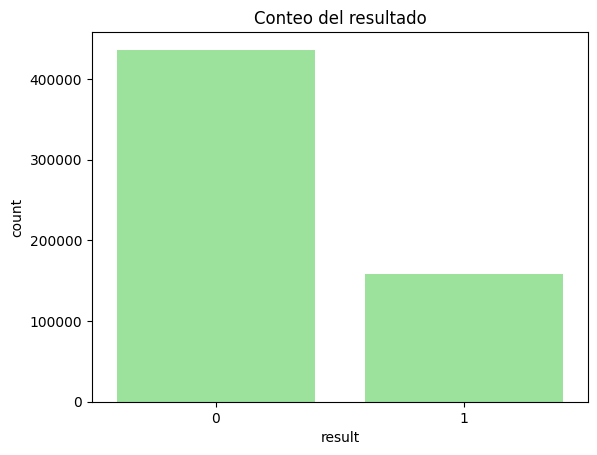

In [71]:
sns.countplot(data = data,
              x = target,
              color = 'lightgreen')
              
plt.title('Conteo del resultado')
plt.show()

Create decision tree classifier which target would be the outcome

In [98]:
# split data into X and y matrices
X = data[features].copy()
y = data[target].copy()

# encode cat features
encoder = TargetEncoder(target_type = 'binary',
                        random_state = 123).set_output(transform = 'pandas')

# create transformer
transformer = make_column_transformer((encoder, make_column_selector(dtype_include = 'object')),
                                      remainder = 'passthrough',
                                      verbose_feature_names_out = False).set_output(transform = 'pandas')

# declare decision tree classifier
dtc = DecisionTreeClassifier(max_depth = 5,
                             min_samples_split = 0.05,
                             min_samples_leaf = 0.05,
                             random_state = 123)

# create pipeline
dtc_pipe = make_pipeline(transformer, dtc)

# train decision classifier
dtc_pipe.fit(X, y)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('targetencoder',
                                                  TargetEncoder(random_state=123,
                                                                target_type='binary'),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7feb99abe750>)],
                                   verbose_feature_names_out=False)),
                ('decisiontreeclassifier',
                 DecisionTreeClassifier(max_depth=5, min_samples_leaf=0.05,
                                        min_samples_split=0.05,
                                        random_state=123))])

In [99]:
dtc_pipe.score(X, y)

0.7577602796709161

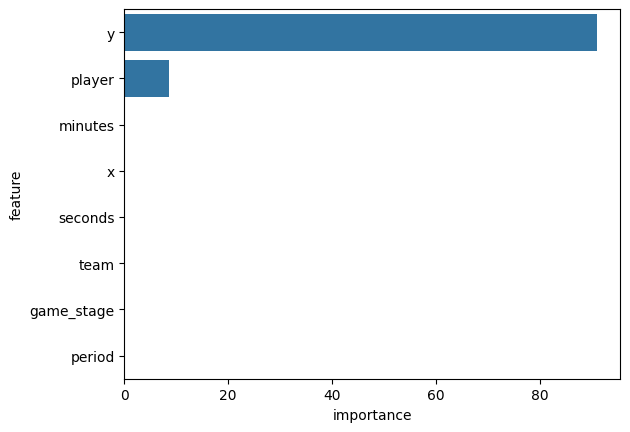

In [100]:
importance = pd.DataFrame({'feature': dtc_pipe[-1].feature_names_in_,
                           'importance': dtc_pipe[-1].feature_importances_ * 100})\
               .sort_values(by = 'importance', ascending = False, ignore_index = True)

sns.barplot(data = importance,
            x = 'importance',
            y = 'feature')
plt.show()